In [1]:
import sys
import numpy as np
import scipy.interpolate as si
import os
import scipy.optimize
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join, expanduser

sys.path.append("../src")  # relative path from notebooks/ to src/
import JCM_models.xray_compounds as xc
import JCM_models.jcm_plotting_utils as JCMgrid
from JCM_models import Shape, ShapeGenerator

#import geo_3 as geometry
#print(os.path.expanduser('~')) 
home = os.path.expanduser('~')


#jcm_root = join(home,'JCMwave/JCMsuite_6_2_1/ThirdPartySupport/Python')
#jcm_root = join(home,'JCMwave/JCMsuite_6_4_8/ThirdPartySupport/Python')
jcm_root = join(home,'JCMwave/JCMsuite_6_6_4/ThirdPartySupport/Python')
sys.path.append(jcm_root)
import jcmwave

import pint
unit = pint.UnitRegistry()

#import pythia.Misc as MISC

#from paramiko import SSHClient

#import json

import pandas as pd

import pickle 

#import xraylib

import time

import matplotlib as mpl
import matrixmethod as mm
mpl.rcParams['font.family'] = ['sans']
mpl.rcParams['font.serif'] = ['DejaVu Sans']

In [2]:
jcmwave.daemon.shutdown()
jcmwave.daemon.add_workstation(
    Hostname="localhost",
    # Login='andrle01',
    Multiplicity=3,
    NThreads=12,
)

[1207891373, 696881717, 698609743]

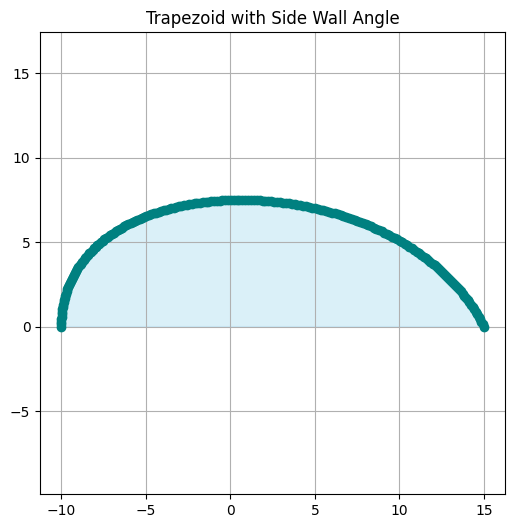

🔷 Shape: Bsplines
• Control points: [(15, 0), (10, 10), (-10, 10), (-10, 0)]
• Centered option available via `.centered()`


In [3]:


# Example usage
#params = {'height': [50,10], 'width': [20,10,20],'corner_radii': {3: 2.0, 2: 1.0}}
#params = {'height': 50, 'width': 20,'corner_radii': {3: 2.0, 2: 1.0}}
params = {'control_points':[(15,0),(10,10),(-10,10),(-10,0)]}
gen = ShapeGenerator('bsplines', params)

gen.plot(title="Trapezoid with Side Wall Angle")
print(gen.describe())

In [6]:
gen.centered() #generate() #.flatten()

[(np.float64(12.5), np.float64(0.0)),
 (np.float64(12.423491221923612), np.float64(0.14999621221686318)),
 (np.float64(12.34473642168571), np.float64(0.2984773111790106)),
 (np.float64(12.26376224700686), np.float64(0.4454432968864423)),
 (np.float64(12.180595345607614), np.float64(0.5908941693391581)),
 (np.float64(12.095262365208532), np.float64(0.7348299285371582)),
 (np.float64(12.007789953530182), np.float64(0.8772505744804423)),
 (np.float64(11.918204758293117), np.float64(1.0181561071690108)),
 (np.float64(11.826533427217909), np.float64(1.1575465266028637)),
 (np.float64(11.732802608025102), np.float64(1.2954218327820004)),
 (np.float64(11.637038948435267), np.float64(1.4317820257064218)),
 (np.float64(11.539269096168958), np.float64(1.5666271053761271)),
 (np.float64(11.43951969894674), np.float64(1.6999570717911163)),
 (np.float64(11.33781740448918), np.float64(1.8317719249513904)),
 (np.float64(11.23418886051682), np.float64(1.962071664856948)),
 (np.float64(11.1286607147502

In [3]:
thick = np.array([20,35,1.2] )
rough = np.array([0,0,0,0] )
wl = [13.5]
ang_deg = np.array([90])#np.linspace(0.1, 2.0, 10001)
ang = np.deg2rad(ang_deg)
nk_TOK = [1-0.023+0.00419j]
nk_Chaucer = [1-0.0226+0.0048j]
nk_SOG = [1-0.0195-0.006j]
nk_sub = np.conjugate(xc.refractive_index('Si',wl* unit.nm,density=2.33))
nk_sub_oxid = np.conjugate(xc.refractive_index('SiO2',wl* unit.nm,density=2.0929729034348785))

thick_noUL = np.array([20,1.2] )
rough_noUL = np.array([0,0,0] )
keys = {'uol1': 1e-9,
        'fem_deg': 4,}

#keys['energy'] = energy[i_taken_energy].to(unit.keV, 'sp').magnitude
#print(keys['energy'])
keys['pol'] = [1, 0] #1,0 s pol 0,1 p pol
keys['lamb'] = wl[0] * 1e-9
keys['slc'] = 1
slc=1
keys['nk'] = [ 1 + 0 * 1j, #vacuum
              nk_TOK, #nk_Si3N4, #layer on top of the substrate
              nk_SOG, #material of the grating
            nk_sub_oxid, #Background
              nk_sub, #surface_matt
             ]
keys['name_domain'] = ['vacuum','resist','UL','oxide','substrate']

pitch = 2
p2 = pitch /2
substrate_offset = 30
vacuum_offset = 30
y = np.sum(thick)

keys['points_cd'] = np.array([-p2,-substrate_offset,p2,-substrate_offset,p2,y+vacuum_offset,-p2,y+vacuum_offset])
keys['points_substrate'] = np.array([-p2,-substrate_offset,p2,-substrate_offset,p2,0,-p2,0])
keys['points_substrate_oxide'] = np.array([-p2,0,p2,0,p2,thick[-1],-p2,thick[-1]])
keys['points_UL'] = np.array([-p2,thick[-1],p2,thick[-1],p2,np.sum(thick[-2:]),-p2,np.sum(thick[-2:])])
keys['points_resist'] = np.array([-p2,np.sum(thick[-2:]),p2,np.sum(thick[-2:]),p2,y,-p2,y])

shape = [
    Shape('ComputationalDomain',domain_id = 1,priority=-1,side_length_constraint=slc,points=keys['points_cd'], nk = 1 ),
    Shape('substrate',domain_id = 2,priority=1,side_length_constraint=slc,points=keys['points_substrate'], nk = nk_sub ),
    Shape('substrate_oxide',domain_id = 3,priority=2,side_length_constraint=slc,points=keys['points_substrate_oxide'], nk = nk_sub_oxid ),
    Shape('UL',domain_id = 4,priority=2,side_length_constraint=slc,points=keys['points_UL'], nk = nk_SOG ),
    Shape('resist',domain_id = 5,priority=2,side_length_constraint=slc,points=keys['points_resist'], nk = nk_TOK ),
]
shape[0].domain_id
keys['shape']=shape
keys['energy_index'] = 0

In [61]:
print(shape[0].describe())

Shape: ComputationalDomain
  Domain ID: 1
  Priority: -1
  Side Length Constraint: 1
  Refractive Index (nk): 1
  Permittivity (ε): 1



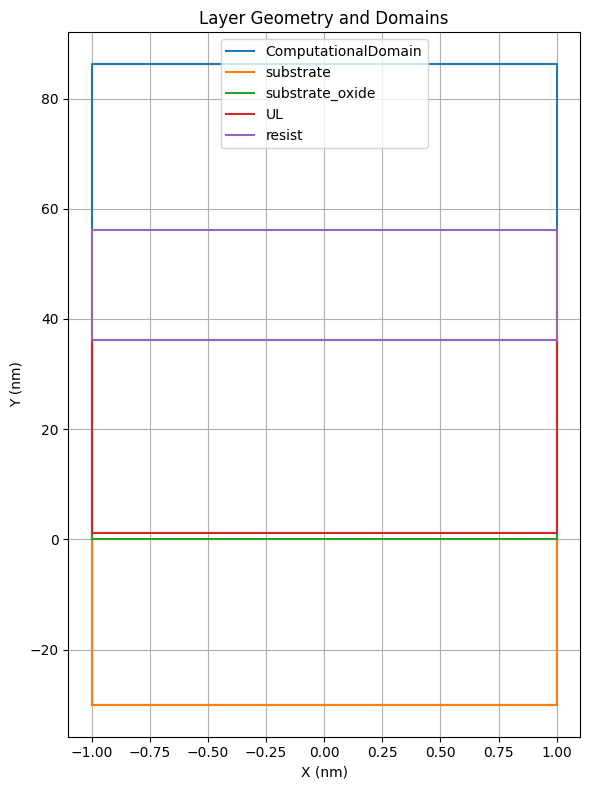

In [5]:
import matplotlib.pyplot as plt

# Create a shared figure and axis
fig, ax = plt.subplots(figsize=(6, 8))

# Plot each shape
for s in shape:
    s.plot(ax=ax)

# Final touches
ax.set_xlabel("X (nm)")
ax.set_ylabel("Y (nm)")
ax.set_title("Layer Geometry and Domains")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

In [48]:
jcmwave.geo("../JCM_clean/",keys=keys)

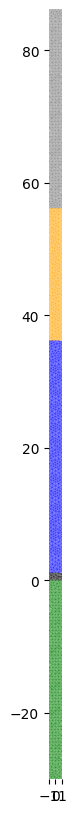

In [6]:
fig, ax = plt.subplots(figsize=(10, 10))

JCMgrid.plot_grid(
    "../JCM_clean/grid.jcm",
    ax=ax,
    colors={1: "grey", 2: "green", 3: "black", 4: "blue", 5: "orange", 6: "pink"},
    alpha=0.5,
    lw=0.2,
)
ax.set_xlim(-p2, p2)
ax.set_ylim(-substrate_offset, y+vacuum_offset)
ax.set_frame_on(False)
# remove ticks and labels
#ax.set_xticks([])
#ax.set_yticks([])
ax.set_aspect("equal")

In [7]:
ids = []

keys['slc'] = 0.7

keys['phi']=90
keys['angle_of_incidence']= 0 #-82 #87.285796
#results = jcmwave.solve("./BlazedGrating/JCM_clean/project.jcmpt",keys=keys)
ids.append(
    jcmwave.solve('../JCM_clean/project-field.jcmpt',  keys=keys, temporary=True)
)
#results = [results]

results, logs = jcmwave.daemon.wait(ids, verbose=False)

In [8]:
results

[[{'file': '/tmp/__JCMwave__4qvnxkhu/project-field_results/fieldbag.jcm',
   'computational_costs': {'title': 'ComputationalCosts',
    'header': {'AccumulatedCPUTime': 3.370329,
     'AccumulatedTotalTime': 0.539170279},
    'Level': array([0], dtype=int32),
    'Unknowns': array([43136], dtype=int32),
    'CpuTime': array([3.174451]),
    'CpuPerUnknown': array([7.35916868e-05]),
    'TotalTime': array([0], dtype=int32),
    'SystemMemory_GB': array([0.02986145]),
    'MaxNodeSystemMemory_GB': array([0.02986145]),
    'TotalMemory_GB': array([0.1755867]),
    'MaxNodeTotalMemory_GB': array([0.1755867]),
    'CpuTimeAssembling': array([0.520478]),
    'CpuTimeSolve': array([0.435197]),
    'CpuTimeInnerNodeUpdate': array([0.131794]),
    'TotalTimeAssembling': array([0.05694267]),
    'TotalTimeSolve': array([0.07471476]),
    'TotalTimeInnerNodeUpdate': array([0.01077609]),
    'FEDegree0_Percentage': array([0.]),
    'FEDegree1_Percentage': array([0.]),
    'FEDegree2_Percentage': a